<a href="https://colab.research.google.com/github/gabsgt/FIAP-EY-Fase5/blob/main/bank_customer_churn_F5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Objetivo:
Classificar os clientes que provavelmente fariam portabilidade, ou seja, deixariam de ser clientes do branco.

In [60]:
!pip install imblearn

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importando pacotes

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint
import graphviz

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE

In [63]:
df = pd.read_csv('/content/drive/MyDrive/FIAP - Atividades/Fase 5/dataset/bank_customer.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Análise exploratória

Temos 10000 observações, e 14 colunas. Dados aparentemente não apresentam dados faltantes.

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Deletando variaveis que não achamos importantes para o modelo.

In [65]:
df.drop(['RowNumber', 'CustomerId', 'Surname', 'Geography'], axis=1, inplace=True)

In [66]:
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Female,43,2,125510.82,1,1,1,79084.10,0


Vamos explorar cada variável

Categóricas:

In [67]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [68]:
df['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

Vemos que 20% da base de clientes saíram do portfolio. O que no nosso modelo corresponderia que 20% poderia fazer uma portabilidade.

In [69]:
df['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

In [70]:
df['Tenure'].value_counts(sort=True)

2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: Tenure, dtype: int64

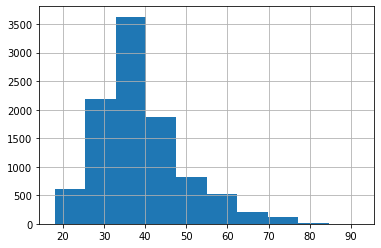

In [71]:
df['Age'].hist()

In [72]:
df['NumOfProducts'].value_counts()

1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64

In [73]:
df['IsActiveMember'].value_counts()

1    5151
0    4849
Name: IsActiveMember, dtype: int64

Numéricas:

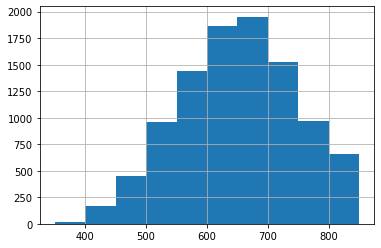

In [74]:
df['CreditScore'].hist()

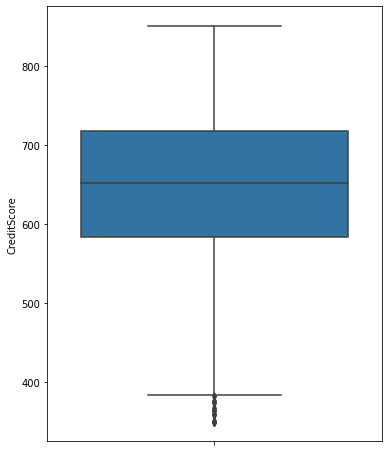

In [75]:
plt.figure(figsize=(6,8))
sns.boxplot(y=df['CreditScore'])
plt.show()

Encontram-se outliers com score baixo.

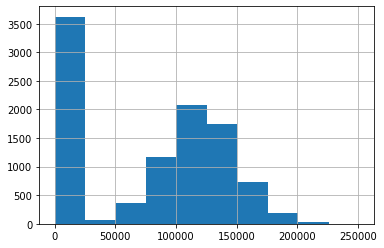

In [76]:
df['Balance'].hist()

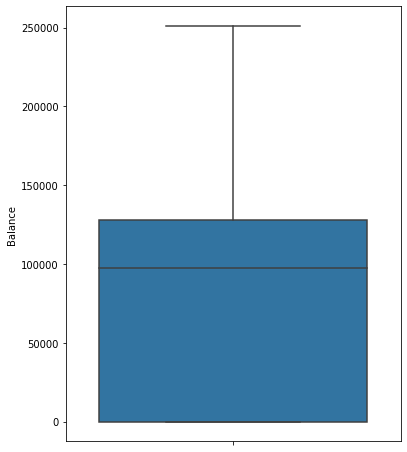

In [77]:
plt.figure(figsize=(6,8))
sns.boxplot(y=df['Balance'])
plt.show()

In [78]:
df['EstimatedSalary'].describe().T

count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: EstimatedSalary, dtype: float64

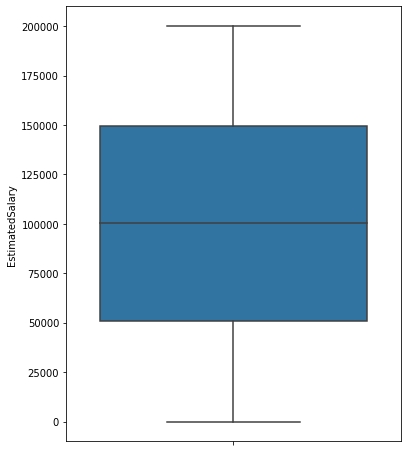

In [79]:
plt.figure(figsize=(6,8))
sns.boxplot(y=df['EstimatedSalary'])
plt.show()

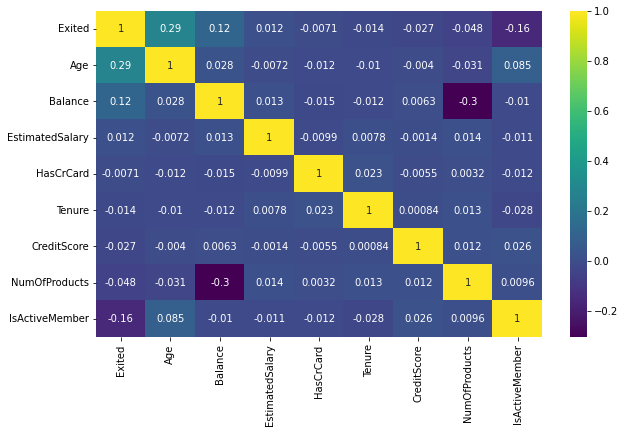

In [80]:
k = 10
cols = df.corr().nlargest(k, 'Exited')['Exited'].index
cm = df[cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap = 'viridis')

### Feature Engineering

In [81]:
df.drop(['Gender', 'Age'], axis=1, inplace=True)

In [110]:
df.drop('IsActiveMember', axis=1, inplace=True)

In [111]:
df.head()

,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,EstimatedSalary,Exited
0,-0.326221,-1.041760,-1.225848,-0.911583,1,0.021886,1
1,-0.440036,-1.387538,0.117350,-0.911583,0,0.216534,0
2,-1.536794,1.032908,1.333053,2.527057,1,0.240687,1
3,0.501521,-1.387538,-1.225848,0.807737,0,-0.108918,0
4,2.063884,-1.041760,0.785728,-0.911583,1,-0.365276,0


Como vimos acima, o dataset está desbalanceado por possuir apenas 20% dos clientes da classe 'Exited'. Será necessário balancear os dados para o modelo aprender melhor. Para isto, vamos usar a técnica SMOTE.

In [112]:
smt = SMOTE()

In [113]:
X = df.drop(['Exited'], axis=1)
y = df['Exited']

In [114]:
X, y = smt.fit_sample(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [115]:
np.bincount(y)

array([7963, 7963])

In [116]:
scaler = StandardScaler()
df['Balance'] = scaler.fit_transform(df[['Balance']])
df['EstimatedSalary'] = scaler.fit_transform(df[['EstimatedSalary']])
df['CreditScore'] = scaler.fit_transform(df[['CreditScore']])
df['Tenure'] = scaler.fit_transform(df[['Tenure']])
df['NumOfProducts'] = scaler.fit_transform(df[['NumOfProducts']])

In [117]:
df.head()

,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,EstimatedSalary,Exited
0,-0.326221,-1.041760,-1.225848,-0.911583,1,0.021886,1
1,-0.440036,-1.387538,0.117350,-0.911583,0,0.216534,0
2,-1.536794,1.032908,1.333053,2.527057,1,0.240687,1
3,0.501521,-1.387538,-1.225848,0.807737,0,-0.108918,0
4,2.063884,-1.041760,0.785728,-0.911583,1,-0.365276,0


### Modelling

Separando X e Y:

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, stratify=y, test_size=0.2)

Função para o score report:

In [119]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

Positivo: o cliente fará a portabilidade

Negativo: o cliente não fará a portabilidade

Falso Positivo: diz que fará a portabilidade, mas não faz. 

Falso Negativo: diz que não fará a portabilidade, mas faz. 

Verdadeiro Positivo: Diz que fará a portabilidade, e faz.

Verdadeiro negativo: diz que não fará a portabilidade, e não faz.

### Regressão Logística:

In [120]:
lr = LogisticRegression()

In [121]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [122]:
y_pred = lr.predict(X_test)

In [123]:
print(accuracy_score(y_test, y_pred)*100)

56.340238543628374


In [124]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.46      0.51      1593
           1       0.55      0.66      0.60      1593

    accuracy                           0.56      3186
   macro avg       0.57      0.56      0.56      3186
weighted avg       0.57      0.56      0.56      3186



O resultado do modelo de Regressão Logística não é tão satisfatório. Vamos explorar um outro.

### Árvore de Decisão

In [125]:
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [126]:
print_score(clf, X_train, y_train, X_test, y_test, train=True)
print_score(clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 69.99%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy     macro avg  weighted avg
precision     0.735528     0.673667  0.699922      0.704598      0.704598
recall        0.624333     0.775510  0.699922      0.699922      0.699922
f1-score      0.675384     0.721010  0.699922      0.698197      0.698197
support    6370.000000  6370.000000  0.699922  12740.000000  12740.000000
_______________________________________________
Confusion Matrix: 
 [[3977 2393]
 [1430 4940]]

Test Result:
Accuracy Score: 68.02%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.720769     0.652174  0.680163     0.686472      0.686472
recall        0.588198     0.772128  0.680163     0.680163      0.680163
f1-score      0.647770     0.707100  0.680163     0.677435      0.677435
support    1593.000000  159

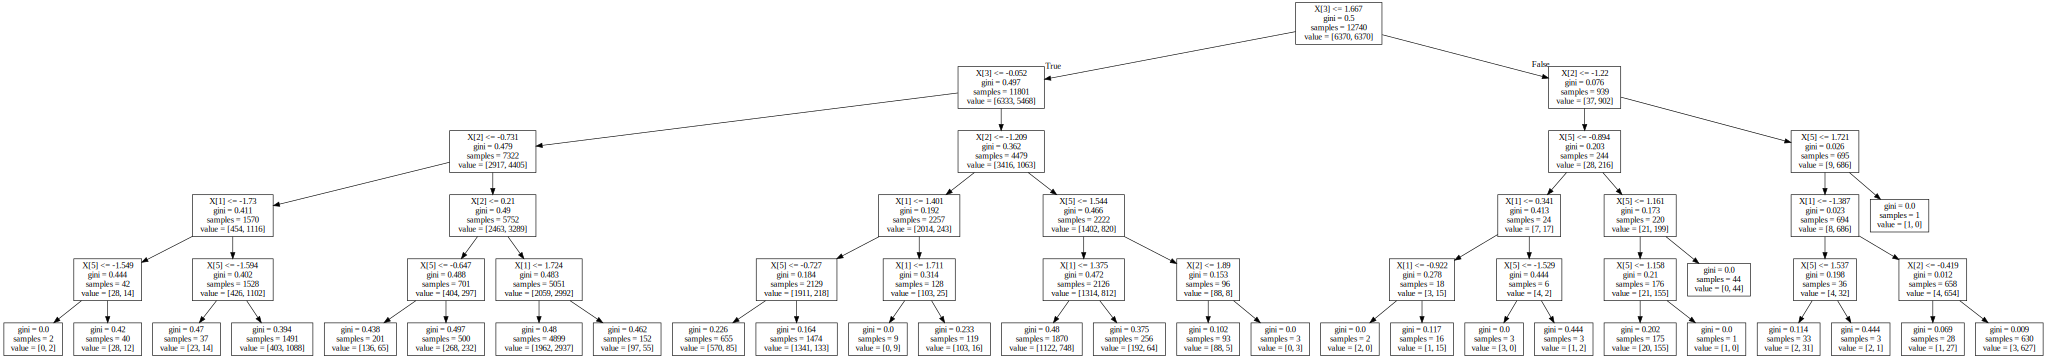

In [127]:
tree_graph_clf = tree.export_graphviz(clf, out_file=None)
graphviz.Source(tree_graph_clf)

## Otimização dos hiperparametros

In [128]:
SEED = 123456

In [129]:
espaco_de_parametros = {
    "max_depth" : randint(1, 10),
    "min_samples_split" : randint(32, 129),
    "min_samples_leaf" : randint(32, 129),
    "criterion" : ["gini", "entropy"]
}

In [130]:
modelo_arvore = DecisionTreeClassifier()

clf = RandomizedSearchCV(modelo_arvore, espaco_de_parametros, random_state=SEED, cv=5, return_train_score=True, n_iter=10, scoring='accuracy')
search = clf.fit(X, y)
results_RandomizedSearchCV = search.cv_results_
indice_melhores_parametros = search.best_index_

In [131]:
print(f"mean_train_score {results_RandomizedSearchCV['mean_train_score'][indice_melhores_parametros]:.2f}")
print(f"mean_test_score {results_RandomizedSearchCV['mean_test_score'][indice_melhores_parametros]:.2f}")

mean_train_score 0.70
mean_test_score 0.69


In [132]:
results_RandomizedSearchCV['params'][indice_melhores_parametros]

{'criterion': 'gini',
 'max_depth': 7,
 'min_samples_leaf': 66,
 'min_samples_split': 46}

In [133]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf=79, min_samples_split=82)
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=79, min_samples_split=82,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [134]:
print_score(clf, X_train, y_train, X_test, y_test, train=True)
print_score(clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 69.64%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy     macro avg  weighted avg
precision     0.734621     0.668871  0.696389      0.701746      0.701746
recall        0.614914     0.777865  0.696389      0.696389      0.696389
f1-score      0.669458     0.719263  0.696389      0.694360      0.694360
support    6370.000000  6370.000000  0.696389  12740.000000  12740.000000
_______________________________________________
Confusion Matrix: 
 [[3917 2453]
 [1415 4955]]

Test Result:
Accuracy Score: 67.77%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.719380     0.649262  0.677652     0.684321      0.684321
recall        0.582549     0.772756  0.677652     0.677652      0.677652
f1-score      0.643774     0.705646  0.677652     0.674710      0.674710
support    1593.000000  159

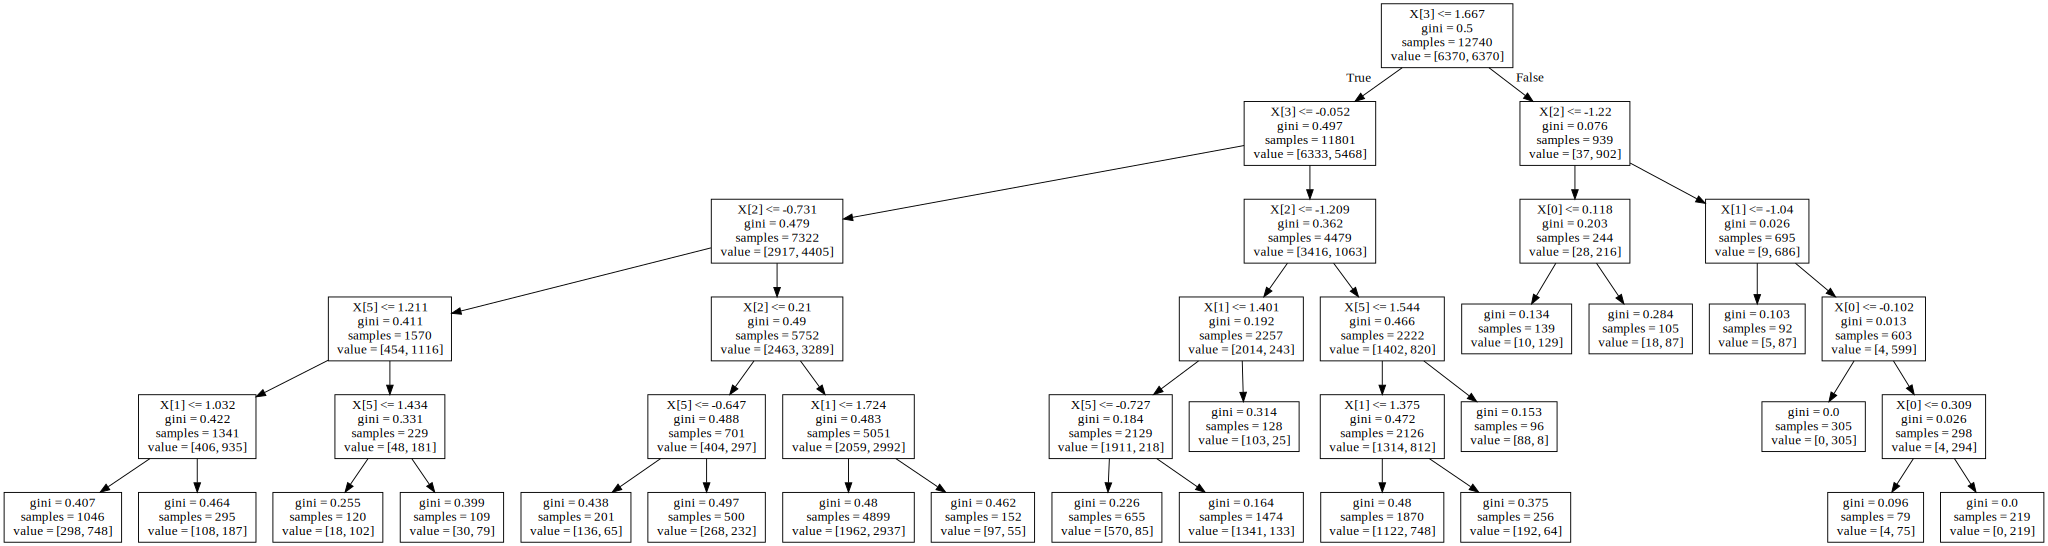

In [135]:
tree_graph_clf = tree.export_graphviz(clf, out_file=None)
graphviz.Source(tree_graph_clf)

### **Feature Importance**

In [136]:
importance = clf.feature_importances_

Feature 0: CreditScore

Feature 1: Tenure

Feature 2: Balance

Feature 3: NumOfProducts

Feature 4: HasCrCard

Feature 5: EstimatedSalary

In [137]:
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.00105
Feature: 1, Score: 0.02196
Feature: 2, Score: 0.16293
Feature: 3, Score: 0.79457
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.01950


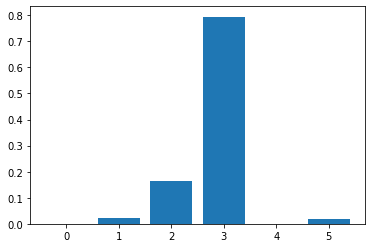

In [138]:
plt.bar([x for x in range(len(importance))], importance)
plt.show()

### **Infos deploy:**
**MODELO:** 

clf

**Variáveis:**

'CreditScore' = Score de Crédito

'Tenure' = Tempo de Relacionamento com o banco

'Balance' = Balanço da conta

'NumOfProducts' = Número de Produtos

'HasCrCard' = Tem cartão de crédito (checkbox)

'EstimatedSalary'= Salário

In [139]:
from sklearn.externals import joblib

In [149]:
joblib.dump(clf, 'model_portabilidade_v3.pkl')

['model_portabilidade_v3.pkl']

In [150]:
!ls

drive  model_portabilidade.pkl	model_portabilidade_v3.pkl  sample_data


In [151]:
model = joblib.load('model_portabilidade_v3.pkl')

### Testes

In [145]:
#'CreditScore', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary'
teste1 = np.array([[750, 4, 155000, 3, 1, 149388]])
print('É provável que saia do banco: ', model.predict(teste1))
print('Probabilidade de 0 e 1: ', model.predict_proba(teste1))

É provável que saia do banco:  [1]
Probabilidade de 0 e 1:  [[0. 1.]]


In [146]:
#'CreditScore', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary'
teste2 = np.array([[430, 1, 96000, 1, 1, 76000]])
print('É provável que saia do banco: ', model.predict(teste2))
print('Probabilidade de 0 e 1: ', model.predict_proba(teste2))

É provável que saia do banco:  [0]
Probabilidade de 0 e 1:  [[0.91666667 0.08333333]]


In [147]:
#'CreditScore', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary'
teste3 = np.array([[140, 2, 34000, 1, 0, 43000]])
print('É provável que saia do banco: ', model.predict(teste3))
print('Probabilidade de 0 e 1: ', model.predict_proba(teste3))

É provável que saia do banco:  [0]
Probabilidade de 0 e 1:  [[0.91666667 0.08333333]]


In [148]:
#'CreditScore', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary'
teste4 = np.array([[960, 5, 567000, 3, 1, 230000]])
print('É provável que saia do banco: ', model.predict(teste4))
print('Probabilidade de 0 e 1: ', model.predict_proba(teste4))

É provável que saia do banco:  [1]
Probabilidade de 0 e 1:  [[0. 1.]]
